# Medford Disaster Router
<br>
<b>Contributors: Michael Ruggiero, Cengiz Imga, Dali Souayah

# Index

1. [Problem Statement](#PS)
2. [Data Preparation](#Data)
    1. [Major Road Functions](#MRF)
    2. [Routing](#Route)
    3. [Disaster Radius](#Dis)
    4. [Edge Manipulation and Visualizations](#EM)
3. [Dataset Creation](#Maker)
    1. [Data Cleaning](#Clean)
    2. [Statistics](#Stats)

In [1]:
#Import Libraries

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import geopandas as gpd
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
ox.__version__

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## 1. Problem Statement <a id = "PS"></a>

1) Build a NLP model that identifies peaks in twitter (or other social media) that would hint to road closures or disasters locations with Google maps

2) translate those identified locations into flags in a map

3) reflect the affected roads into a map in red color

4) produce a map of valid rescue roads/escape routes

## 2. Data Collection/Import Medford <a id = "Data"></a>

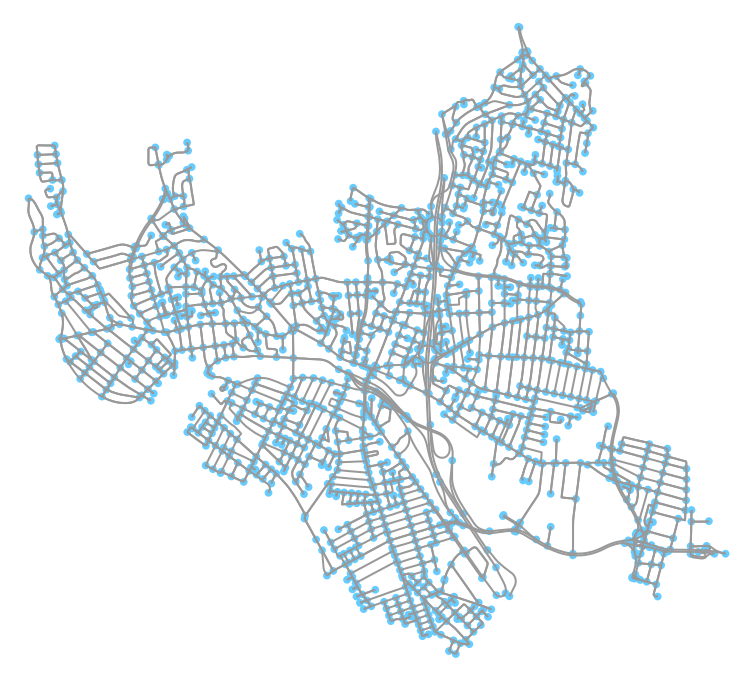

In [3]:
# get a graph for some city
place = {'city' : 'Medford',
         'state' : 'MA',
         'country' : 'USA'}
medford = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(medford)

In [4]:
# what sized area does our network cover in square meters?
medford_proj = ox.project_graph(medford)
nodes_proj = ox.graph_to_gdfs(medford_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

21010917.099306576

In [5]:
# show basic stats about the network
medford_stats = ox.basic_stats(medford_proj, 
                               area=graph_area_m, 
                               clean_intersects=True,
                               circuity_dist='euclidean')

# medford_stats = ox.extended_stats(medford_proj, ecc=True, bc=True, cc=True)

pd.DataFrame(medford_stats).set_index("streets_per_node_counts")

,n,m,k_avg,intersection_count,streets_per_node_avg,streets_per_node_proportion,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion,clean_intersection_count,clean_intersection_density_km
streets_per_node_counts,,,,,,,,,,,,,,,,,,,
0,1569,3862,4.922881,1361,2.905672,0.000000,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765
208,1569,3862,4.922881,1361,2.905672,0.132569,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765
4,1569,3862,4.922881,1361,2.905672,0.002549,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765
1094,1569,3862,4.922881,1361,2.905672,0.697259,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765
254,1569,3862,4.922881,1361,2.905672,0.161887,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765
9,1569,3862,4.922881,1361,2.905672,0.005736,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765


##### Edge and Node Dataframe

In [6]:
# Edge and Node projection
nodes_med, edges_med = ox.graph_to_gdfs(medford, nodes=True, edges=True)

In [7]:
nodes_med.head(2)

,highway,osmid,ref,x,y,geometry
66478081,turning_circle,66478081,NaN,-71.100780,42.429287,POINT (-71.1007798 42.4292871)
1095962629,traffic_signals,1095962629,NaN,-71.110312,42.415123,POINT (-71.1103119 42.4151234)


In [72]:
#Number of intersections
nodes_med.shape

(1569, 7)

## 2a. Major Roads Functions<a id = "MRF"></a>

In [107]:
l = list(major_roads.keys())

MA 16
MA 16;MA 38
MA 60
MA 38
I 93
MA 28
MA 38;MA 60


In [109]:
keys = list(major_roads.keys())

In [112]:
def random_color_matrix(dictionary):
    """generates a random RBG dictionary from three linspaces"""
    
    keys = list(dictionary.keys()) 
    size = len(keys) + 1
    
    A = np.linspace(0,.999, size)
    np.random.shuffle(A)

    B = np.linspace(0,.999, size)
    np.random.shuffle(B)

    C = np.linspace(0,.999, size)
    np.random.shuffle(C)
    
    color_dictionary = {0 : [A[0],B[0],C[0]]}

    for i in range(len(keys)):
        color_dictionary[keys[i]] = [A[i + 1],B[i + 1],C[i + 1]]
    
    return color_dictionary

In [113]:
random_color_matrix(major_roads)

{0: [0.1427142857142857, 0.1427142857142857, 0.1427142857142857],
 'MA 16': [0.7135714285714285, 0.5708571428571428, 0.42814285714285716],
 'MA 16;MA 38': [0.5708571428571428, 0.42814285714285716, 0.8562857142857143],
 'MA 60': [0.999, 0.999, 0.7135714285714285],
 'MA 38': [0.0, 0.0, 0.2854285714285714],
 'I 93': [0.42814285714285716, 0.8562857142857143, 0.999],
 'MA 28': [0.2854285714285714, 0.2854285714285714, 0.0],
 'MA 38;MA 60': [0.8562857142857143, 0.7135714285714285, 0.5708571428571428]}

In [82]:
def node_labeler(node, dictionary, paint):
    """labeles nodes based on dictionary entries"""
    
    answer = []
    for key in dictionary:
        if node in dictionary[key]:
            answer.append(key)

    if len(answer) == 0: return 0
    elif len(answer) == 1: return answer[0]
    else: return " ".join(answer)
        
def node_roader(df,ndf):
    """df is the edge projection, ndf is the node projection
    
       returns major_road dictionary
    """
    
    major_roads = set(df[df.ref.notna()].ref.values)
    major_roads = dict.fromkeys(major_roads, set())
    
    for road in major_roads:
        print("{} nodes in {}".format(len(df[df.ref == road]),
                                         road))
              
        major_roads[road] = set(df[df.ref == road].u) | \
                            set(df[df.ref == road].v)
        
    ndf["major"] = ndf.osmid.apply(lambda a: node_labeler(a, major_roads))
    
    return major_roads

In [83]:
major_roads = node_roader(edges_med,nodes_med)

51 nodes in MA 16
4 nodes in MA 16;MA 38
143 nodes in MA 60
96 nodes in MA 38
12 nodes in I 93
76 nodes in MA 28
5 nodes in MA 38;MA 60


In [81]:
nodes_med.head(2)

,highway,osmid,ref,x,y,geometry,major
66478081,turning_circle,66478081,NaN,-71.100780,42.429287,POINT (-71.1007798 42.4292871),0
1095962629,traffic_signals,1095962629,NaN,-71.110312,42.415123,POINT (-71.1103119 42.4151234),MA 38


In [60]:
medford = ox.gdfs_to_graph(nodes_med, edges_med)

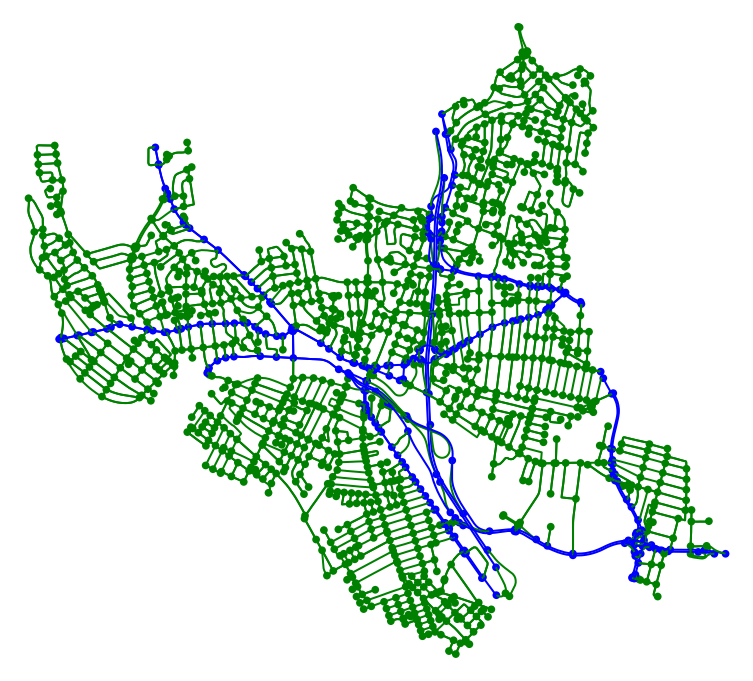

(<Figure size 650.491x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1280541d0>)

In [71]:
def node_painter(df, ndf, dictionary):
    """paints graphs based on dictionary"""
    pass
    




nc = ['blue' if i in list(nodes_med[nodes_med.major != 0].osmid)\
      else 'green' for i in medford.nodes()]

ec = ["blue" if i in list(edges_med[edges_med.ref.notna()].osmid)\
      else 'green' for i in edges_med.osmid]

ox.plot_graph(test,
              node_size=15,
              node_color = nc
              ,edge_color= ec) #np.random.rand(3,)


In [62]:
#Long Lat information 
nodes_med[["x","y"]].describe()

,x,y
count,1569.000000,1569.000000
mean,-71.107867,42.419430
std,0.015947,0.010365
min,-71.145410,42.396426
25%,-71.118687,42.411989
50%,-71.105661,42.420096
75%,-71.095526,42.426626
max,-71.073105,42.444456


In [63]:
#Random Node Sampler
nodes_med[["x","y"]].sample(1).values

array([[-71.096041,  42.423257]])

## 2b. Routing<a id = "Route"></a>

In [16]:
#Random Point Generator
def random_point(lower = -180, higher = 180):
    return (np.random.uniform(low=lower, high=higher),
            np.random.uniform(low=lower, high=higher))

print(random_point())

(-106.8869120551884, -101.88248791398176)


In [17]:
random_point_A = random_point()
random_point_B = random_point()

# get the nearest network node to each random point
orig_node = ox.get_nearest_node(medford, random_point_A)
dest_node = ox.get_nearest_node(medford, random_point_B)

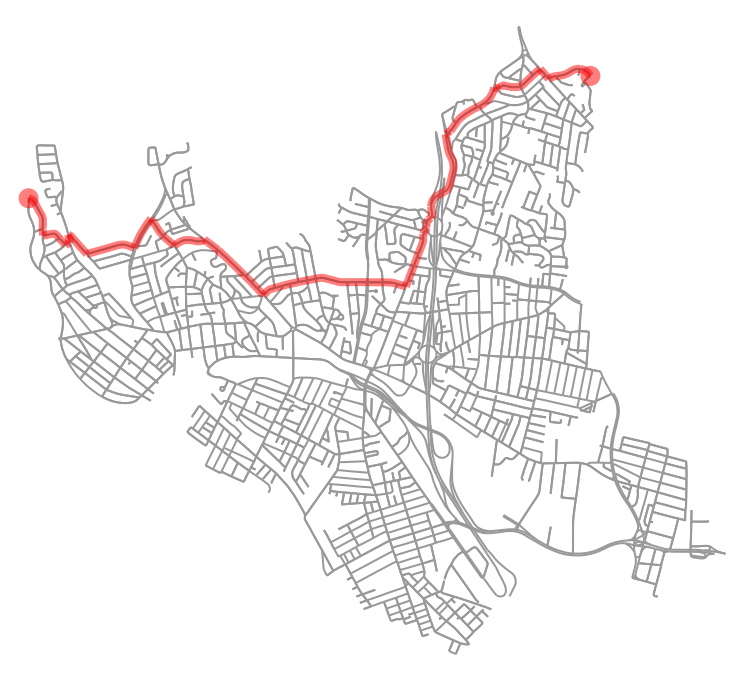

In [18]:
# find the route between these nodes then plot it
route = nx.shortest_path(medford, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(medford, route, node_size=0)

In [19]:
# Length of route in meters
nx.shortest_path_length(medford, orig_node, dest_node, weight='length')

7183.238000000002

In [20]:
# Absolute Distance between two nodes (as the crow flies)
ox.great_circle_vec(medford.node[orig_node]['y'], medford.node[orig_node]['x'],
                    medford.node[dest_node]['y'], medford.node[dest_node]['x'])

4895.140017272379

## 2c. Disaster Radius<a id = "Dis"></a>

In [32]:
nodes_med[["y","x"]].sample(1).values[0]

array([ 42.4271721, -71.0992377])

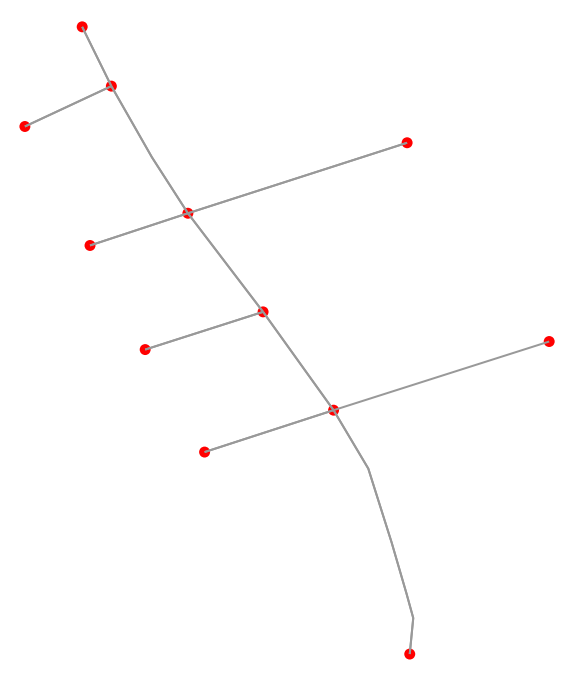

In [33]:
# define a point at the corner of a box
location_point = nodes_med[["y","x"]].sample(1).values[0]

# create network from point, inside bounding box of N, S, E, W each 1750m from point
disaster = ox.graph_from_point(location_point,
                         distance=1000*np.random.uniform(),
                         distance_type='network',
                         network_type='drive')
disaster = ox.project_graph(disaster)
fig, ax = ox.plot_graph(disaster, node_size=30, node_color='red')

In [23]:
nodes_dis, edges_dis = ox.graph_to_gdfs(disaster)

In [24]:
edges_dis.head(2)

,geometry,highway,key,lanes,length,name,oneway,osmid,ref,u,v,width
0,LINESTRING (327668.2311191462 4698758.42735542...,secondary,0,2,31.494,Salem Street,False,82863211,MA 60,66434052,66469612,18.9
1,LINESTRING (327668.2311191462 4698758.42735542...,secondary,0,2,39.252,Salem Street,False,82863211,MA 60,66434052,66439675,18.9


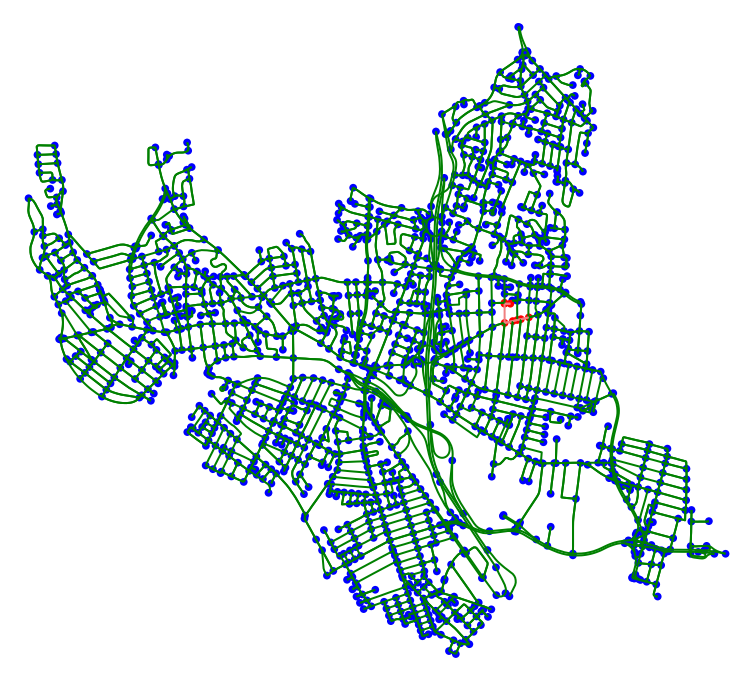

(<Figure size 650.491x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x125dd1208>)

In [25]:
#Set Colors
ec = ['lightcoral' if i in disaster.edges() else 'green' for i in medford.edges()]
nc = ['red' if i in disaster.nodes() else 'blue' for i in medford.nodes()]

#Plot energency grid
ox.plot_graph(medford, node_size=15, node_color = nc ,edge_color=ec)


In [26]:
live = []

for i in medford.edges():
    if i not in disaster.edges():
        live.append(i[0])

In [27]:
live = edges_med[edges_med["u"].isin(live)]

In [28]:
live.size

61744

In [29]:
edges_med.size

61792

In [30]:
med_live = ox.gdfs_to_graph(nodes_med, live)

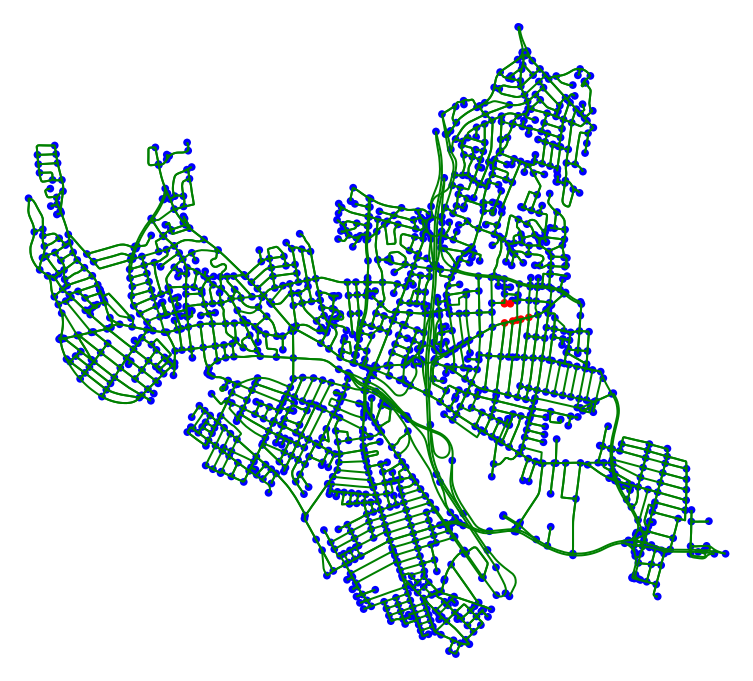

In [31]:
ox.plot_graph(med_live, node_size=15, node_color = nc ,edge_color="g");

## 2d. Edge Manipulation and Visualizations<a id = "EM"></a>

In [ ]:
# get the boundary polygons for neighboring cities, save as shapefile, project to UTM, and plot
place_names = ['Medford, MA, USA', 
               'Arlington, MA, USA',
               'Somerville, MA, USA',
               'Malden, MA, USA',
#                'Melrose, MA, USA',
               'Winchester, MA, USA',
               'Stoneham, MA, USA',
               'Everett, MA, USA',
              ]
medford_area = ox.gdf_from_places(place_names)
fig, ax = ox.plot_shape(medford_area)

In [ ]:
# Roads colored by edge length
ec = ox.get_edge_colors_by_attr(medford, attr='length', num_bins=200)
fig, ax = ox.plot_graph(medford, node_color='w', node_edgecolor='k', node_size=5, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3)

In [ ]:
# highlight one-way roads
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in medford.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(medford, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

In [ ]:
# edge closeness centrality: convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(medford))

# list of edge values for the orginal graph
ev = [edge_centrality[edge + (0,)] for edge in medford.edges()]

# color scale converted to list of colors for graph edges
norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
fig, ax = ox.plot_graph(medford, bgcolor='k', axis_off=True, node_size=0,
                        edge_color=ec, edge_linewidth=1.5, edge_alpha=1)

In [ ]:
# Buffer radius around Medford
medford_buffered = ox.gdf_from_place(place, buffer_dist=250)
fig, ax = ox.plot_shape(medford_buffered)

In [ ]:
#Neighboor hoods buffered
neigboors_buffered = ox.gdf_from_places(place_names, gdf_name='neighboors', buffer_dist=250)
fig, ax = ox.plot_shape(neigboors_buffered, alpha=0.7)

In [ ]:
# plot same network again (topologically isomorphic), this time ignoring the edges' spatial geometry
ec = ox.get_edge_colors_by_attr(medford, attr='length')
fig, ax = ox.plot_graph(medford, node_color='w', node_edgecolor='k', node_size=5, node_zorder=3, 
                           edge_color=ec, edge_linewidth=3, edge_alpha=1, use_geom=False)

## 3. Data Creation <a id = "Maker"></a>

In [ ]:
# network from address, including only nodes within 6.5km along the network from city hall
G4 = ox.graph_from_address(address='85 George P. Hassett Drive,\
                                    Medford, MA 02155',
                           distance=6500, distance_type='network', network_type='drive')

# you can project the network to UTM (zone calculated automatically)
G4_projected = ox.project_graph(G4)
fig, ax = ox.plot_graph(G4_projected)

In [ ]:
# Edge and Node projection
nodes_area, edges_area = ox.graph_to_gdfs(G4,
                                        nodes=True,
                                        edges=True)

In [ ]:
print(nodes_med.shape)
print(nodes_area.shape)

In [ ]:
nc = ['blue' if i in medford.nodes() else 'green' for i in G4.nodes()]


In [ ]:
ox.plot_graph(G4_projected,
              node_size=15,
              node_color = nc);


In [ ]:
# find the route between these nodes then plot it
route = nx.shortest_path(G4, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(G4_projected, route, node_size=0)

In [ ]:
route = nx.average_shortest_path_length(G4_projected)

# fig, ax = ox.plot_graph_route(G4_projected, route, node_size=0)

In [ ]:
nx.shortest_simple_paths

In [101]:
len(major_roads)

7

In [102]:
def random_color_matrix(n):
    """generates a random RBG matrix from three linspaces"""
    
    A = np.linspace(0,.999,n)
    np.random.shuffle(A)

    B = np.linspace(0,.999,n)
    np.random.shuffle(B)

    C = np.linspace(0,.999,n)
    np.random.shuffle(C)

    return [[A[i],B[i],C[i]] for i in range(n)]

def painter(df, ndf, dictionary):
"""Makes visually distinct colorings based on dictionary"""

    #generate color matrix for every key and NaN
    colors = random_color_matrix(len(dictionary) + 1)
    road_color = {}
    road_color[0] = colors[0]
    
    for road in dictionary:
        
    
    
    node_c = [colors[i] if i in list( \
                edges_med[edges_med.ref.notna()].osmid)
      else 'green' for i in edges_med.osmid]
    
    




nc = ['blue' if i in list(nodes_med[nodes_med.major != 0].osmid)\
      else 'green' for i in medford.nodes()]

ec = ["blue" if i in list(edges_med[edges_med.ref.notna()].osmid)\
      else 'green' for i in edges_med.osmid]

ox.plot_graph(test,
              node_size=15,
              node_color = nc
              ,edge_color= ec) #np.random.rand(3,)

IndentationError: expected an indented block (<ipython-input-102-5fe4e814709a>, line 16)